In [11]:
import os
import difflib
import graphviz
import owlready2 as owl
import weakref

In [2]:
onto_path = 'file://' + os.path.abspath('ontologies/gistCore9.5.0')
onto = owl.get_ontology(onto_path).load()
print('Loaded owl file at:', onto_path)

Loaded owl file at: file:///Users/lawrence/ontologies/gistCore9.5.0


In [3]:
Project_class=onto.search(iri='*Project*')
print(Project_class)

[gist.Project]


In [4]:
Project_class[0].is_a
print('equivalent_to:', Project_class[0].equivalent_to)
print('has subclasses: ', onto.search(subclass_of=Project_class[0]))
print(Project_class[0].__dict__)

equivalent_to: [gist.Task & gist.hasSubTask.some(gist.Task)]
has subclasses:  [gist.Project]
{'namespace': get_ontology("https://ontologies.semanticarts.com/o/gistCore#").get_namespace("https://ontologies.semanticarts.com/gist/"), 'storid': 507, '_name': 'Project', 'is_a': [owl.Thing], '_equivalent_to': [gist.Task & gist.hasSubTask.some(gist.Task)], '__module__': 'owlready2.entity', '__doc__': None}


In [15]:
for sc in Project_class[0].ancestors():
    print (sc)
for sc in Project_class[0].descendants():
    print (sc)

gist.Project
owl.Thing
gist.Project


In [6]:
Project_class_actually=Project_class[0]

In [13]:
Project_1 = Project_class_actually("Project_1")
Project_2 = Project_class_actually("Project_2")
Project_3 = Project_class_actually("Project_3")

In [19]:
Task_class=onto.search(iri='*Task')
print(Task_class)

[gist.Task, gist.hasSubTask, gist.ScheduledTask, gist.hasDirectSubTask]


In [20]:
Task_class_actually=Task_class[0]

In [22]:
Task_1_1 = Task_class_actually("Task_1_1")
Task_1_2 = Task_class_actually("Task_1_2")
Task_1_3 = Task_class_actually("Task_1_3")

In [ ]:
print (Project_1.name)
print (Project_1.iri)
for p in Project_class_actually.instances():
    print (p.name)
for t in Task_class_actually.instances():
    print (t.name)

In [36]:
Project_1.hasSubTask = [Task_1_1,Task_1_2,Task_1_3]

In [40]:
print (Project_1.get_properties())

{gist.hasSubTask}


In [39]:
Project_1.INDIRECT_hasSubTask

[gist.Task_1_3,
 gist.Event & gist.hasGoal.some(gist.Intention),
 gist.Task_1_2,
 gist.Task,
 gist.Task_1_1,
 gist.Task & gist.hasSubTask.some(gist.Task)]

In [41]:
# Retrieve all object properties
properties = list(onto.object_properties())

In [49]:
h=onto.search(iri='*hasSubTask*')

In [53]:
print(h[0].__dict__)

{'namespace': get_ontology("https://ontologies.semanticarts.com/o/gistCore#").get_namespace("https://ontologies.semanticarts.com/gist/"), 'is_a': [owl.ObjectProperty, owl.TransitiveProperty], 'storid': 509, '_name': 'hasSubTask', '_equivalent_to': [], '__module__': 'owlready2.entity', '__doc__': None, '_domain': None, '_range': None, '_property_chain': None, '_inverse_property': gist.subTaskOf, '_python_name': 'hasSubTask', '_class_property_type': [], '_class_property_some': True, '_class_property_only': False, '_class_property_relation': False, '_inverse_storid': 580}


In [54]:
print('class_property_some:', h[0]._class_property_some)
print('class_property_only:', h[0]._class_property_only)
print('class_property_relation:', h[0]._class_property_relation)

class_property_some: True
class_property_only: False
class_property_relation: False


In [55]:
print('name(string):', h[0].name)
print('module_type:', h[0].__module__)
print('is_a:', h[0].is_a)
print()

name(string): hasSubTask
module_type: owlready2.entity
is_a: [owl.ObjectProperty, owl.TransitiveProperty]



In [58]:
# Default type2str from owlready2
type2str_restriction = owl.class_construct._restriction_type_2_label

def _process_entity(entity, job_name, orig_entity, graph):
    """Helper: Append entity for the specified job.
    """
    edge = (orig_entity, job_name, entity)
    if edge not in graph:
        graph.append(edge)
    return graph

def _process_restriction(restriction, entity, graph):
    """Helper: Append restriction.
    """
    assert restriction.__module__ == 'owlready2.class_construct'
    
    # Grab object_property --type--> value
    object_property, value = restriction.property, restriction.value
    restriction_type = type2str_restriction[restriction.type]
    
    # Separate logical or for 'only'
    if restriction_type == 'only':
        for or_value in value.Classes:
            edge = (entity, '{},{}'.format(object_property.name, restriction_type), or_value)
            if edge not in graph:
                graph.append(edge)
            
    # No more processing for 'some'
    else:
        edge = (entity, '{},{}'.format(object_property.name, restriction_type), value)
        if edge not in graph:
            graph.append(edge)
        
    return graph

def _process_subclasses(entity, graph):
    """Helper: Append subclasses.
    """
    # Safely grab all subclasses
    try:
        subclses = list(entity.subclasses())
    except:
        subclses = []

    for subcls in subclses:
        if (entity, 'has_subclass', subcls) not in graph:
            graph.append((entity, 'has_subclass', subcls))
        if (subcls, 'subclass_of', entity) not in graph:
            graph.append((subcls, 'subclass_of', entity))

    return graph

def _populate_subclass_rel(graph):
    """Helper: Ensure 'subclass_of' and 'has_subclass' always appear in pairs.
    """
    for edge in graph:
        if edge[1] == 'subclass_of' and (edge[2], 'has_subclass', edge[0]) not in graph:
            graph.append((edge[2], 'has_subclass', edge[0]))
        elif edge[1] == 'has_subclass' and (edge[2], 'subclass_of', edge[0]) not in graph:
            graph.append((edge[2], 'subclass_of', edge[0]))
    return graph

def _process_instances(entity, graph):
    """Helper: Append individuals.
    """
    # Safely grab all individuals
    try:
        instances = entity.instances()
    except:
        instances = []

    for instance in instances:
        if instance.is_a[0] == entity:
            if (entity, 'has_individual', instance) not in graph:
                graph.append((entity, 'has_individual', instance))

    return graph

def generate_knowledge_graph(entity):
    """Helper function to grab entity-relation from onto and 
    return as knowledge graph.
    """
    graph = []

    # Part 1: Append subclasses
    graph = _process_subclasses(entity, graph)

    # Part 2: Collect equivalent_to
    try:
        equivalent_to_list = entity.INDIRECT_equivalent_to  # NOTE: Weird bug here, have to use INDIRECT
    except:
        equivalent_to_list = []
    for et in equivalent_to_list:
        # equivalent_to AND objects:
        if et.__module__ == 'owlready2.class_construct':
            for x in et.Classes:
                # For class restriction, retrieve relevant infos inside
                if x.__module__ == 'owlready2.class_construct':
                    graph = _process_restriction(x, entity, graph)
                    
    # Part 3: Look into is_a
    is_a_list = entity.is_a
    for x in is_a_list:
        # Entity: is_a indicates subclasses
        if x.__module__ == 'owlready2.entity':
            graph = _process_entity(x, 'subclass_of', entity, graph)
                
        # Restriction
        elif x.__module__ == 'owlready2.class_construct':
            graph = _process_restriction(x, entity, graph)
        
    # Part 4: Look into instances
    graph = _process_instances(entity, graph)
    
    # Part 5: Some additional filters
    graph = _populate_subclass_rel(graph)
    
    return graph

def _filter_graph(graph, onto):
    """Helper: filter graph from some ill-logical entries.
    """
    filtered_graph = []
    # Grab all individuals
    individuals = list(onto.individuals())

    for edge in graph:
        passed = True
        # Ill-logical individuals
        if edge[0] in individuals:
            passed = False
        if passed:
            filtered_graph.append(edge)
    return filtered_graph

def keyword_search_onto(keyword, onto):
    """Search and index key entity from onto given keyword.
    """
    classes = list(onto.classes())
    classes_str = [x.name for x in classes]
    all_res = difflib.get_close_matches(keyword, classes_str)
    # Only grab the most probable search keyword
    if len(all_res) > 0:
        res = all_res[0]
        return classes[classes_str.index(res)]
    else:
        return None

def _to_string(graph):
    """Helper: Convert everything collected inside graph list into
    string.
    """
    for i in range(len(graph)):
        edge = list(graph[i])
        for k in range(len(edge)):
            if type(edge[k]) is not str:
                edge[k] = edge[k].name
            edge[k] = edge[k].replace(',', ', ')
        graph[i] = (edge[0], edge[1], edge[2])
    return graph

def ontograf_simple(orig_entity, onto):
    """Interface func to search and retrieve infor for a given
    entity inside onto.
    """
    if orig_entity is None:
        return []
    
    # Initial graph search
    graph = generate_knowledge_graph(orig_entity)
    
    # Prep for other key entities given the initial graph
    entities = []
    for edge in graph:
        entities.append(edge[2])

    # 1st-level of filters, append more info from children and parent nodes
    for entity in entities:
        sub_graph = generate_knowledge_graph(entity)
        for edge in sub_graph:
            if edge[2] == orig_entity:
                if (entity, edge[1], orig_entity) not in graph and entity != orig_entity:
                    graph.append((entity, edge[1], orig_entity))

    # 2nd-level of filters, filter some ill-logical nodes
    graph = _filter_graph(graph, onto)

    # Convert everything inside graph into str
    graph = _to_string(graph)

    return graph

In [59]:
def convert_to_graphviz(graph, name='KG'):
    """Helper function to convert edge graph into graphviz.Digraph.
    """
    e = graphviz.Digraph(name)
    e.attr('node', shape='box')
    for edge in graph:
        e.attr('node', shape='box')
        e.node(edge[0])
        e.node(edge[2])
        e.edge(edge[0], edge[2], label=edge[1])
    return e

--------------------
False gist.Project
[('Project', 'hasSubTask, some', 'Task'), ('Project', 'has_individual', 'Project_1'), ('Project', 'has_individual', 'Project_2'), ('Project', 'has_individual', 'Project_3')]


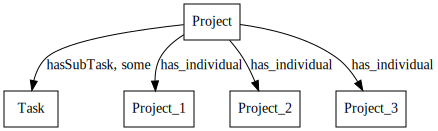

In [60]:
print('-'*20)
entity = keyword_search_onto('Project', onto)
print(entity == onto.Thing, entity)
kg = ontograf_simple(entity, onto)
print(kg)
convert_to_graphviz(kg)